In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel

from importlib import reload
reload(chipmultilabel)

from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

<module 'earthtext.datamodules.chipmultilabel' from '/home/ubuntu/projects/earth-text/src/earthtext/datamodules/chipmultilabel.py'>

# Train on all OSM classes

In [2]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-26 16:50:21.480 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:02 Time:  0:00:020000
2024-04-26 16:50:24.477 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read train split with 58599 chip files (out of 58690)
2024-04-26 16:50:24.478 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-26 16:50:24.853 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-26 16:50:25.490 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read val split with 11822 chip files (out of 11841)
2024-04-26 16:50:25.491 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-

In [3]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

570723

In [4]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.17925 params 0.0367119
epoch   1 step 3662 loss 0.15404 params 0.0544915
epoch   2 step 3662 loss 0.14444 params 0.0785508
epoch   3 step 3662 loss 0.14778 params 0.1038815
epoch   4 step 3662 loss 0.14630 params 0.1298686
epoch   5 step 3662 loss 0.14187 params 0.1555998
epoch   6 step 3662 loss 0.14258 params 0.1813401
epoch   7 step 3662 loss 0.14151 params 0.2071152
epoch   8 step 3662 loss 0.14639 params 0.2328552
epoch   9 step 3662 loss 0.14721 params 0.2587392
epoch  10 step 3662 loss 0.14000 params 0.2845837
epoch  11 step 3662 loss 0.14136 params 0.3105553
epoch  12 step 3662 loss 0.13413 params 0.3366908
epoch  13 step 3662 loss 0.14180 params 0.3627524
epoch  14 step 3662 loss 0.13777 params 0.3887209
epoch  15 step 3662 loss 0.14447 params 0.4147725
epoch  16 step 3662 loss 0.13832 params 0.4410702
epoch  17 step 3662 loss 0.13437 params 0.4675701
epoch  18 step 3662 loss 0.14037 params 0.4940865
epoch  19 step 3662 loss 0.14042 params 0.5206367


Text(0, 0.5, 'loss')

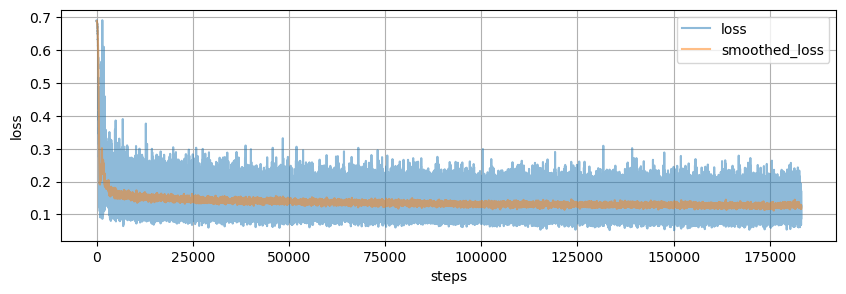

In [5]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")

In [6]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel']

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:12 Time:  0:00:120001


((58599, 99), (58599, 99))

In [7]:
idxs = np.random.permutation(len(targets))[:300]

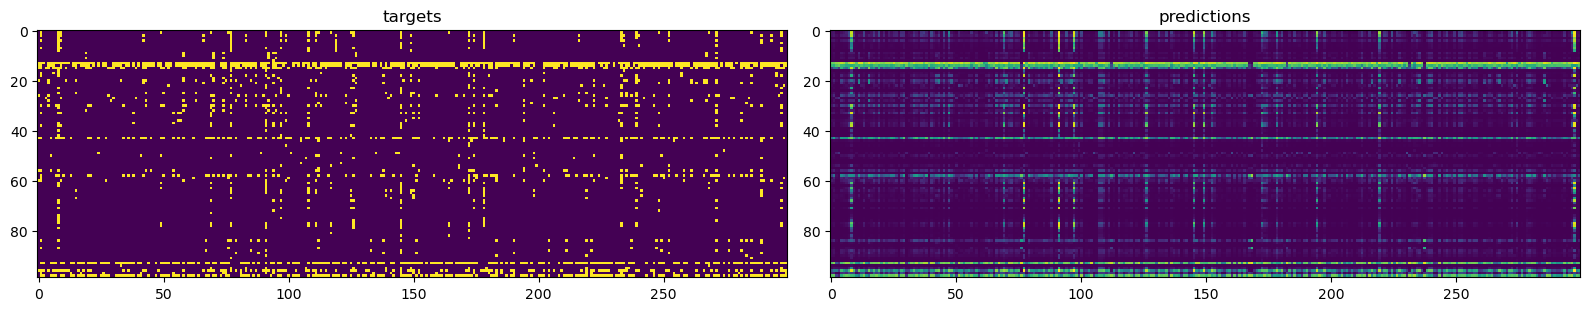

In [8]:
for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

In [9]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
tnr = lambda y_true, y_pred: np.mean(y_true[y_true==0] == y_pred[y_true==0])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None

acc = lambda y_true, y_pred: np.mean(y_true==y_pred)
# 'tpr': 0.5767012011351924,
#  'tnr': 0.9821519242111034,
#  'acc': 0.9543408209300903,
#  'prec': 0.7041051529853083
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'tnr': tnr(y_true, y_pred), 'acc': acc(y_true, y_pred), 'prec': prec(y_true, y_pred)}

In [10]:
metr(targets.flatten(), predictions.flatten()>.5)

{'tpr': 0.5784942350798201,
 'tnr': 0.9808288766830096,
 'acc': 0.9524258437891776,
 'prec': 0.69623787049717}

In [11]:
precision_score(targets.flatten(), predictions.flatten()>.5), \
recall_score(targets.flatten(), predictions.flatten()>.5)

(0.69623787049717, 0.5784942350798201)

In [12]:
r = [metr(targets[:,c], predictions[:,c]>.5) for c in range(targets.shape[-1])]    
r = pd.DataFrame(r)

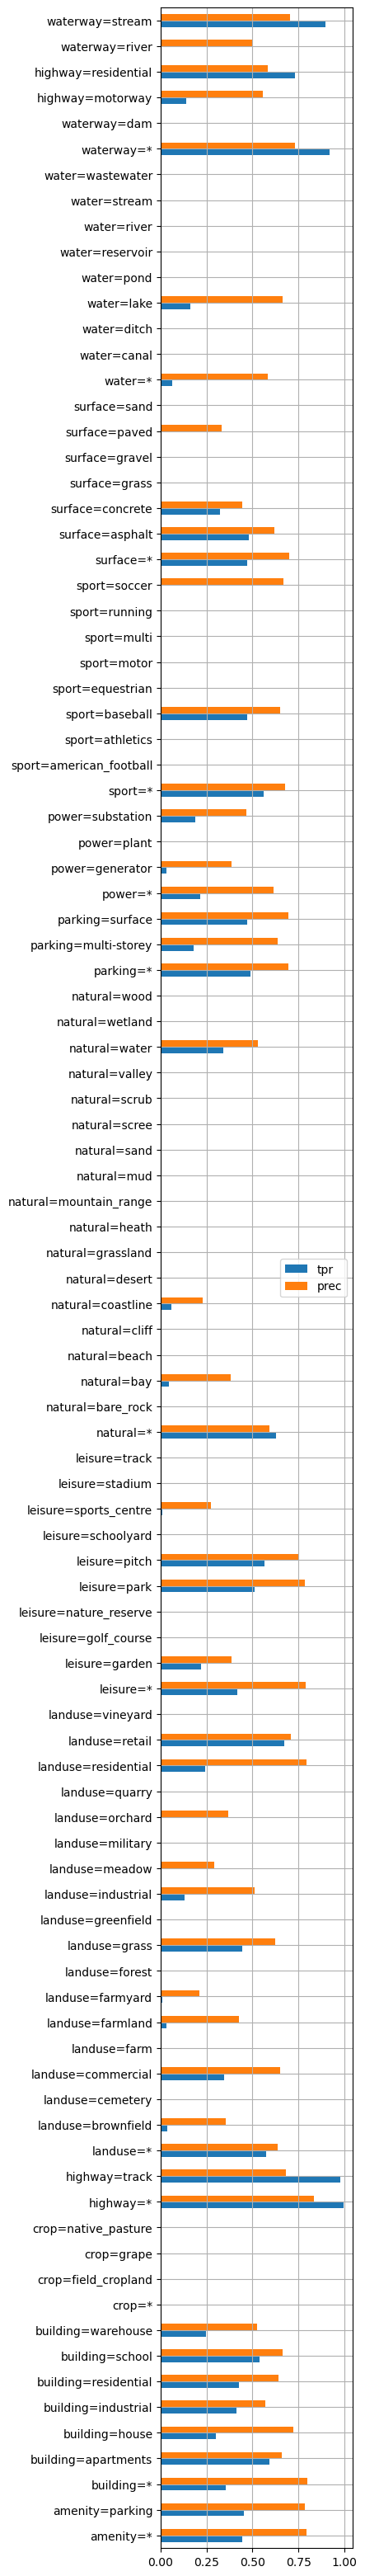

In [31]:
ax = r[['tpr', 'prec']].plot(kind='barh', figsize=(3,40), grid=True)
ax.set_yticklabels(labels=(name_dict[i] for i in range(99)), rotation=0, fontsize=10);

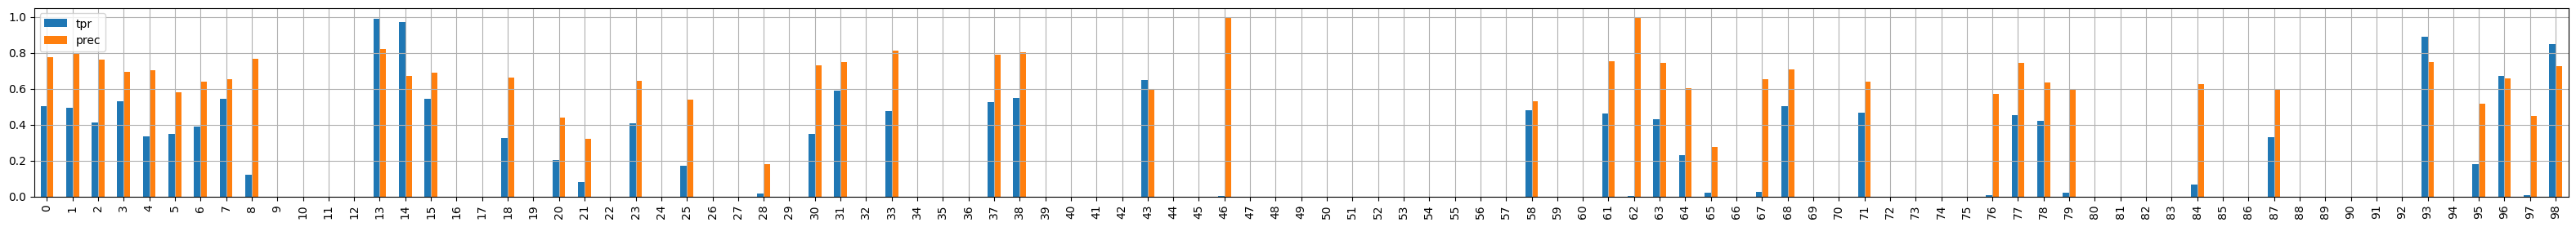

In [15]:
r[['tpr', 'prec']].plot(kind='bar', figsize=(40,3))
plt.grid()

Classes to discard due to recall < .1 :
- 9, 10, 11, 12, 16, 17, 19, 21, 22, 24, 26, 27, 28, 29, 32, 34, 35, 36, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 62, 65, 66, 67, 69, 70, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 97

Classes to retain :
- 0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 18, 20, 23, 25, 30, 31, 33, 37, 38, 43, 58, 61, 63, 64, 68, 71, 77, 78, 87, 93, 95, 96, 98

Difficulty 1 (R,P > .7)
- 13, 14, 93, 98

Difficulty 2 (0.5 <= R <= .7, P >= .7)
- 0, 1, 3, 15, 31, 33, 37, 38, 68, 77

Difficulty 3 (0.1 <= R < .5, P >= .6)
- 2, 4, 8, 18, 30, 61, 63, 71, 78, 87, 96

Difficulty 4 (0.1 <= R < .5, P < .6)
- 5, 6, 7, 20, 23, 25, 43, 58, 64, 95

In [13]:
classes_retain = [0, 1, 2, 3, 4, 5, 6, 7, 8, 13,
                  14, 15, 18, 20, 23, 25, 30, 31, 33, 37,
                  38, 43, 58, 61, 63, 64, 68, 71, 77, 78,
                  87, 93, 95, 96, 98]
classes_difficulty_1 = [13, 14, 93, 98]
classes_difficulty_2 = [0, 1, 3, 15, 31, 33, 37, 38, 68, 77]
classes_difficulty_3 = [2, 4, 8, 18, 30, 61, 63, 71, 78, 87, 96]
classes_difficulty_4 = [5, 6, 7, 20, 23, 25, 43, 58, 64, 95]

In [14]:
from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

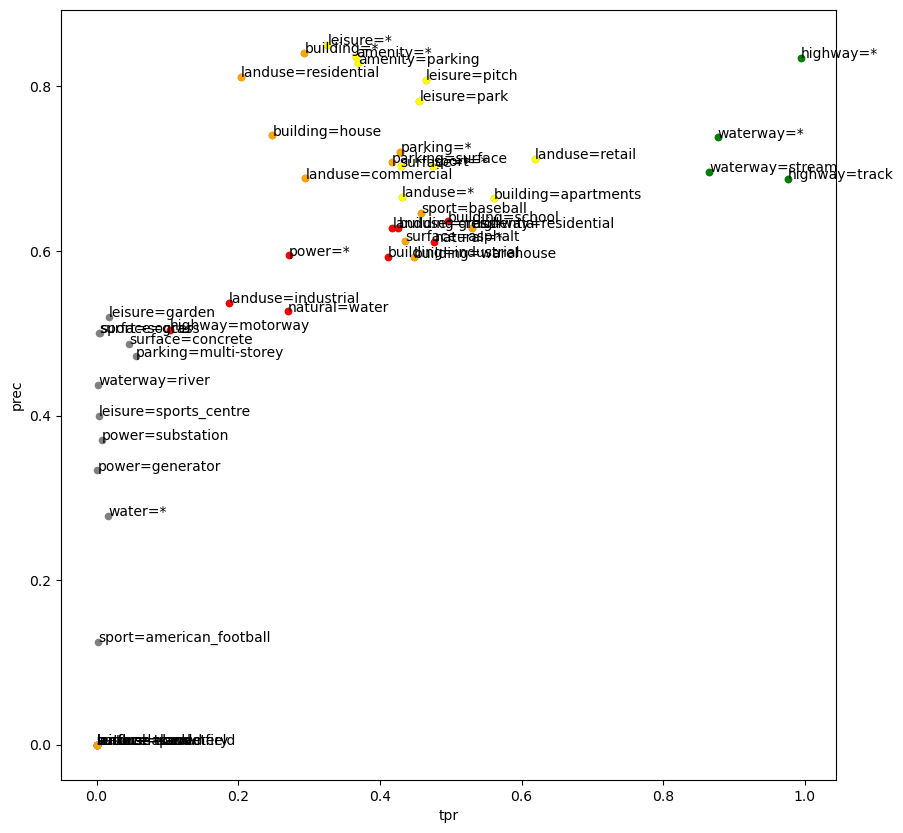

In [166]:
ax = r[['tpr', 'prec']].plot(kind='scatter', x='tpr', y='prec', c='gray', figsize=(10,10))
r[['tpr', 'prec']].loc[classes_difficulty_4].plot(kind='scatter', x='tpr', y='prec', c='red', ax=ax)
r[['tpr', 'prec']].loc[classes_difficulty_3].plot(kind='scatter', x='tpr', y='prec', c='orange', ax=ax)
r[['tpr', 'prec']].loc[classes_difficulty_2].plot(kind='scatter', x='tpr', y='prec', c='yellow', ax=ax)
r[['tpr', 'prec']].loc[classes_difficulty_1].plot(kind='scatter', x='tpr', y='prec', c='green', ax=ax);

for i in range(len(np.array(r.tpr))):
    if not np.isnan(np.array(r.prec)[i]):
        # print(np.array(r.tpr)[i], np.array(r.prec)[i])
        # ax.text(x=np.array(r.tpr)[i], y=np.array(r.prec)[i], s=list(r.index)[i])
        ax.text(x=np.array(r.tpr)[i], y=np.array(r.prec)[i], s=name_dict[list(r.index)[i]], size=10)

# Retrain again only on retained classes

In [34]:
classes_retain = [0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 18, 20, 23, 25, 30, 31, 33, 37,
                  38, 43, 58, 61, 63, 64, 68, 71, 77, 78, 87, 93, 95, 96, 98]

# classes_retain = list(range(99))

In [35]:
for c in classes_retain:
    print(name_dict[c])

amenity=*
amenity=parking
building=*
building=apartments
building=house
building=industrial
building=residential
building=school
building=warehouse
highway=*
highway=track
landuse=*
landuse=commercial
landuse=farmland
landuse=grass
landuse=industrial
landuse=residential
landuse=retail
leisure=*
leisure=park
leisure=pitch
natural=*
natural=water
parking=*
parking=surface
power=*
sport=*
sport=baseball
surface=*
surface=asphalt
water=lake
waterway=*
highway=motorway
highway=residential
waterway=stream


In [36]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
conf.model.output_dim = len(classes_retain)
# conf.model.dropout = True
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-26 17:15:26.891 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-26 17:15:30.195 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read train split with 58599 chip files (out of 58690)
2024-04-26 17:15:30.196 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-26 17:15:30.586 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-26 17:15:31.259 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read val split with 11822 chip files (out of 11841)
2024-04-26 17:15:31.259 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-

In [37]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

562467

In [38]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel'][:, classes_retain]

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.29754 params 0.0372277
epoch   1 step 3662 loss 0.26460 params 0.0537421
epoch   2 step 3662 loss 0.27494 params 0.0765383
epoch   3 step 3662 loss 0.27541 params 0.1000084
epoch   4 step 3662 loss 0.26906 params 0.1235617
epoch   5 step 3662 loss 0.25061 params 0.1471095
epoch   6 step 3662 loss 0.24542 params 0.1713807
epoch   7 step 3662 loss 0.25398 params 0.1962922


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efb3e88d580>
Traceback (most recent call last):
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/conda/envs/earth-text-env/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


epoch   8 step 3662 loss 0.25852 params 0.2214578
epoch   9 step 3662 loss 0.26482 params 0.2471016
epoch  10 step 3662 loss 0.24581 params 0.2729805
epoch  11 step 3662 loss 0.23950 params 0.2986714
epoch  12 step 3662 loss 0.24160 params 0.3243917
epoch  13 step 3662 loss 0.23849 params 0.3499795
epoch  14 step 3662 loss 0.24696 params 0.3751888
epoch  15 step 3662 loss 0.24445 params 0.4004568
epoch  16 step 3662 loss 0.24134 params 0.4258289
epoch  17 step 3662 loss 0.23367 params 0.4513218
epoch  18 step 3662 loss 0.22963 params 0.4767339
epoch  19 step 3662 loss 0.25072 params 0.5022732
epoch  20 step 3662 loss 0.22431 params 0.5279049
epoch  21 step 3662 loss 0.24184 params 0.5535616
epoch  22 step 3662 loss 0.23632 params 0.5792003


KeyboardInterrupt: 

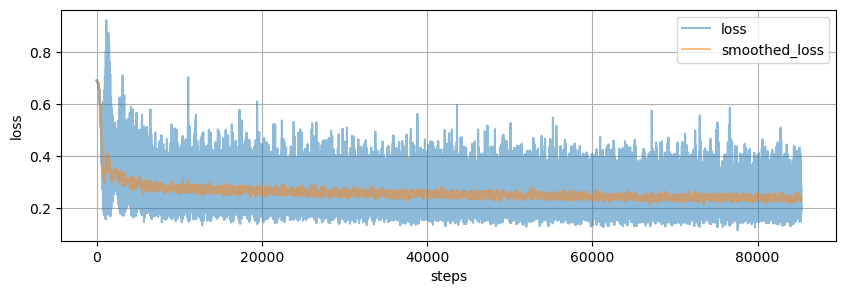

In [39]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");

In [40]:
targets = []
predictions = []
# dltrain = dl.train_dataloader()
dltrain = dl.test_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (817 of 817) |######################| Elapsed Time: 0:00:03 Time:  0:00:030000


((13071, 35), (13071, 35))

In [41]:
idxs = np.random.permutation(len(targets))[:300]

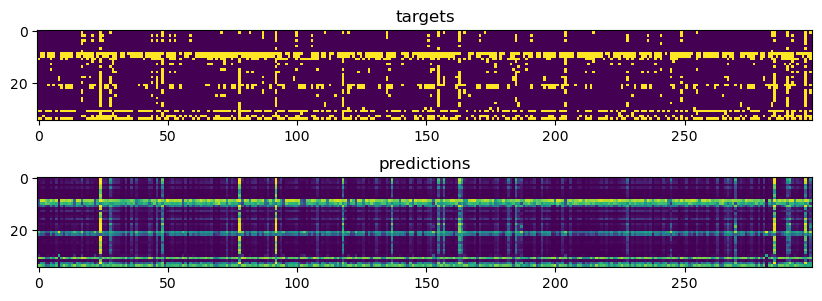

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(10,3.5));
ax[0].imshow(targets[idxs].T, interpolation='none');
ax[0].set_title("targets");
ax[1].imshow(predictions[idxs].T, interpolation='none');
ax[1].set_title("predictions");
# fig.tight_layout()

In [43]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'prec': prec(y_true, y_pred)}

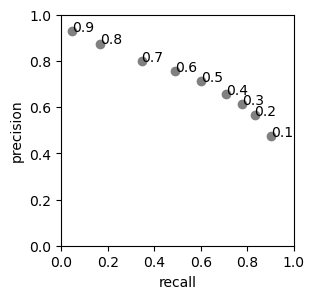

In [44]:
fig = plt.figure(figsize=(3, 3))
for thres in np.arange(.1, 1, .1):
    _rp = metr(targets.flatten(), predictions.flatten()>thres)
    _rec = _rp['tpr']
    _prec = _rp['prec']
    plt.scatter(_rec, _prec, c='gray');
    plt.text(_rec, _prec, round(thres, 1));
plt.xlabel("recall"); plt.ylabel("precision"); plt.xlim(0,1); plt.ylim(0,1);

In [45]:
R = []
for thres in np.linspace(0.1, 1, 20):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

(20, 35, 2)

---

In [46]:
from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

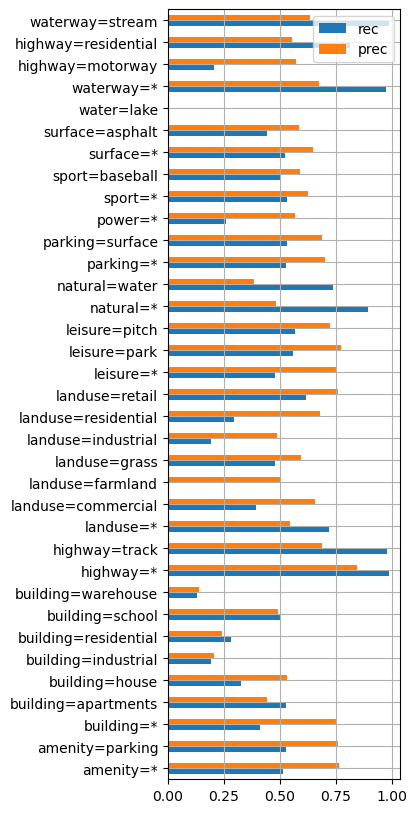

In [49]:
ax = pd.DataFrame(R[5], columns=['rec', 'prec']).plot(kind='barh', figsize=(3,10), grid=True);
ax.set_yticklabels(labels=(name_dict[classes_retain[i]] for i in range(len(classes_retain))), rotation=0, fontsize=10);

- building=residential, warehouse
- crop=*
- crop=grape
- crop=native_pasture
- landuse=brownfield
- landuse=cemetery
- landuse=farm
- landuse=farmyard

<Figure size 640x480 with 0 Axes>

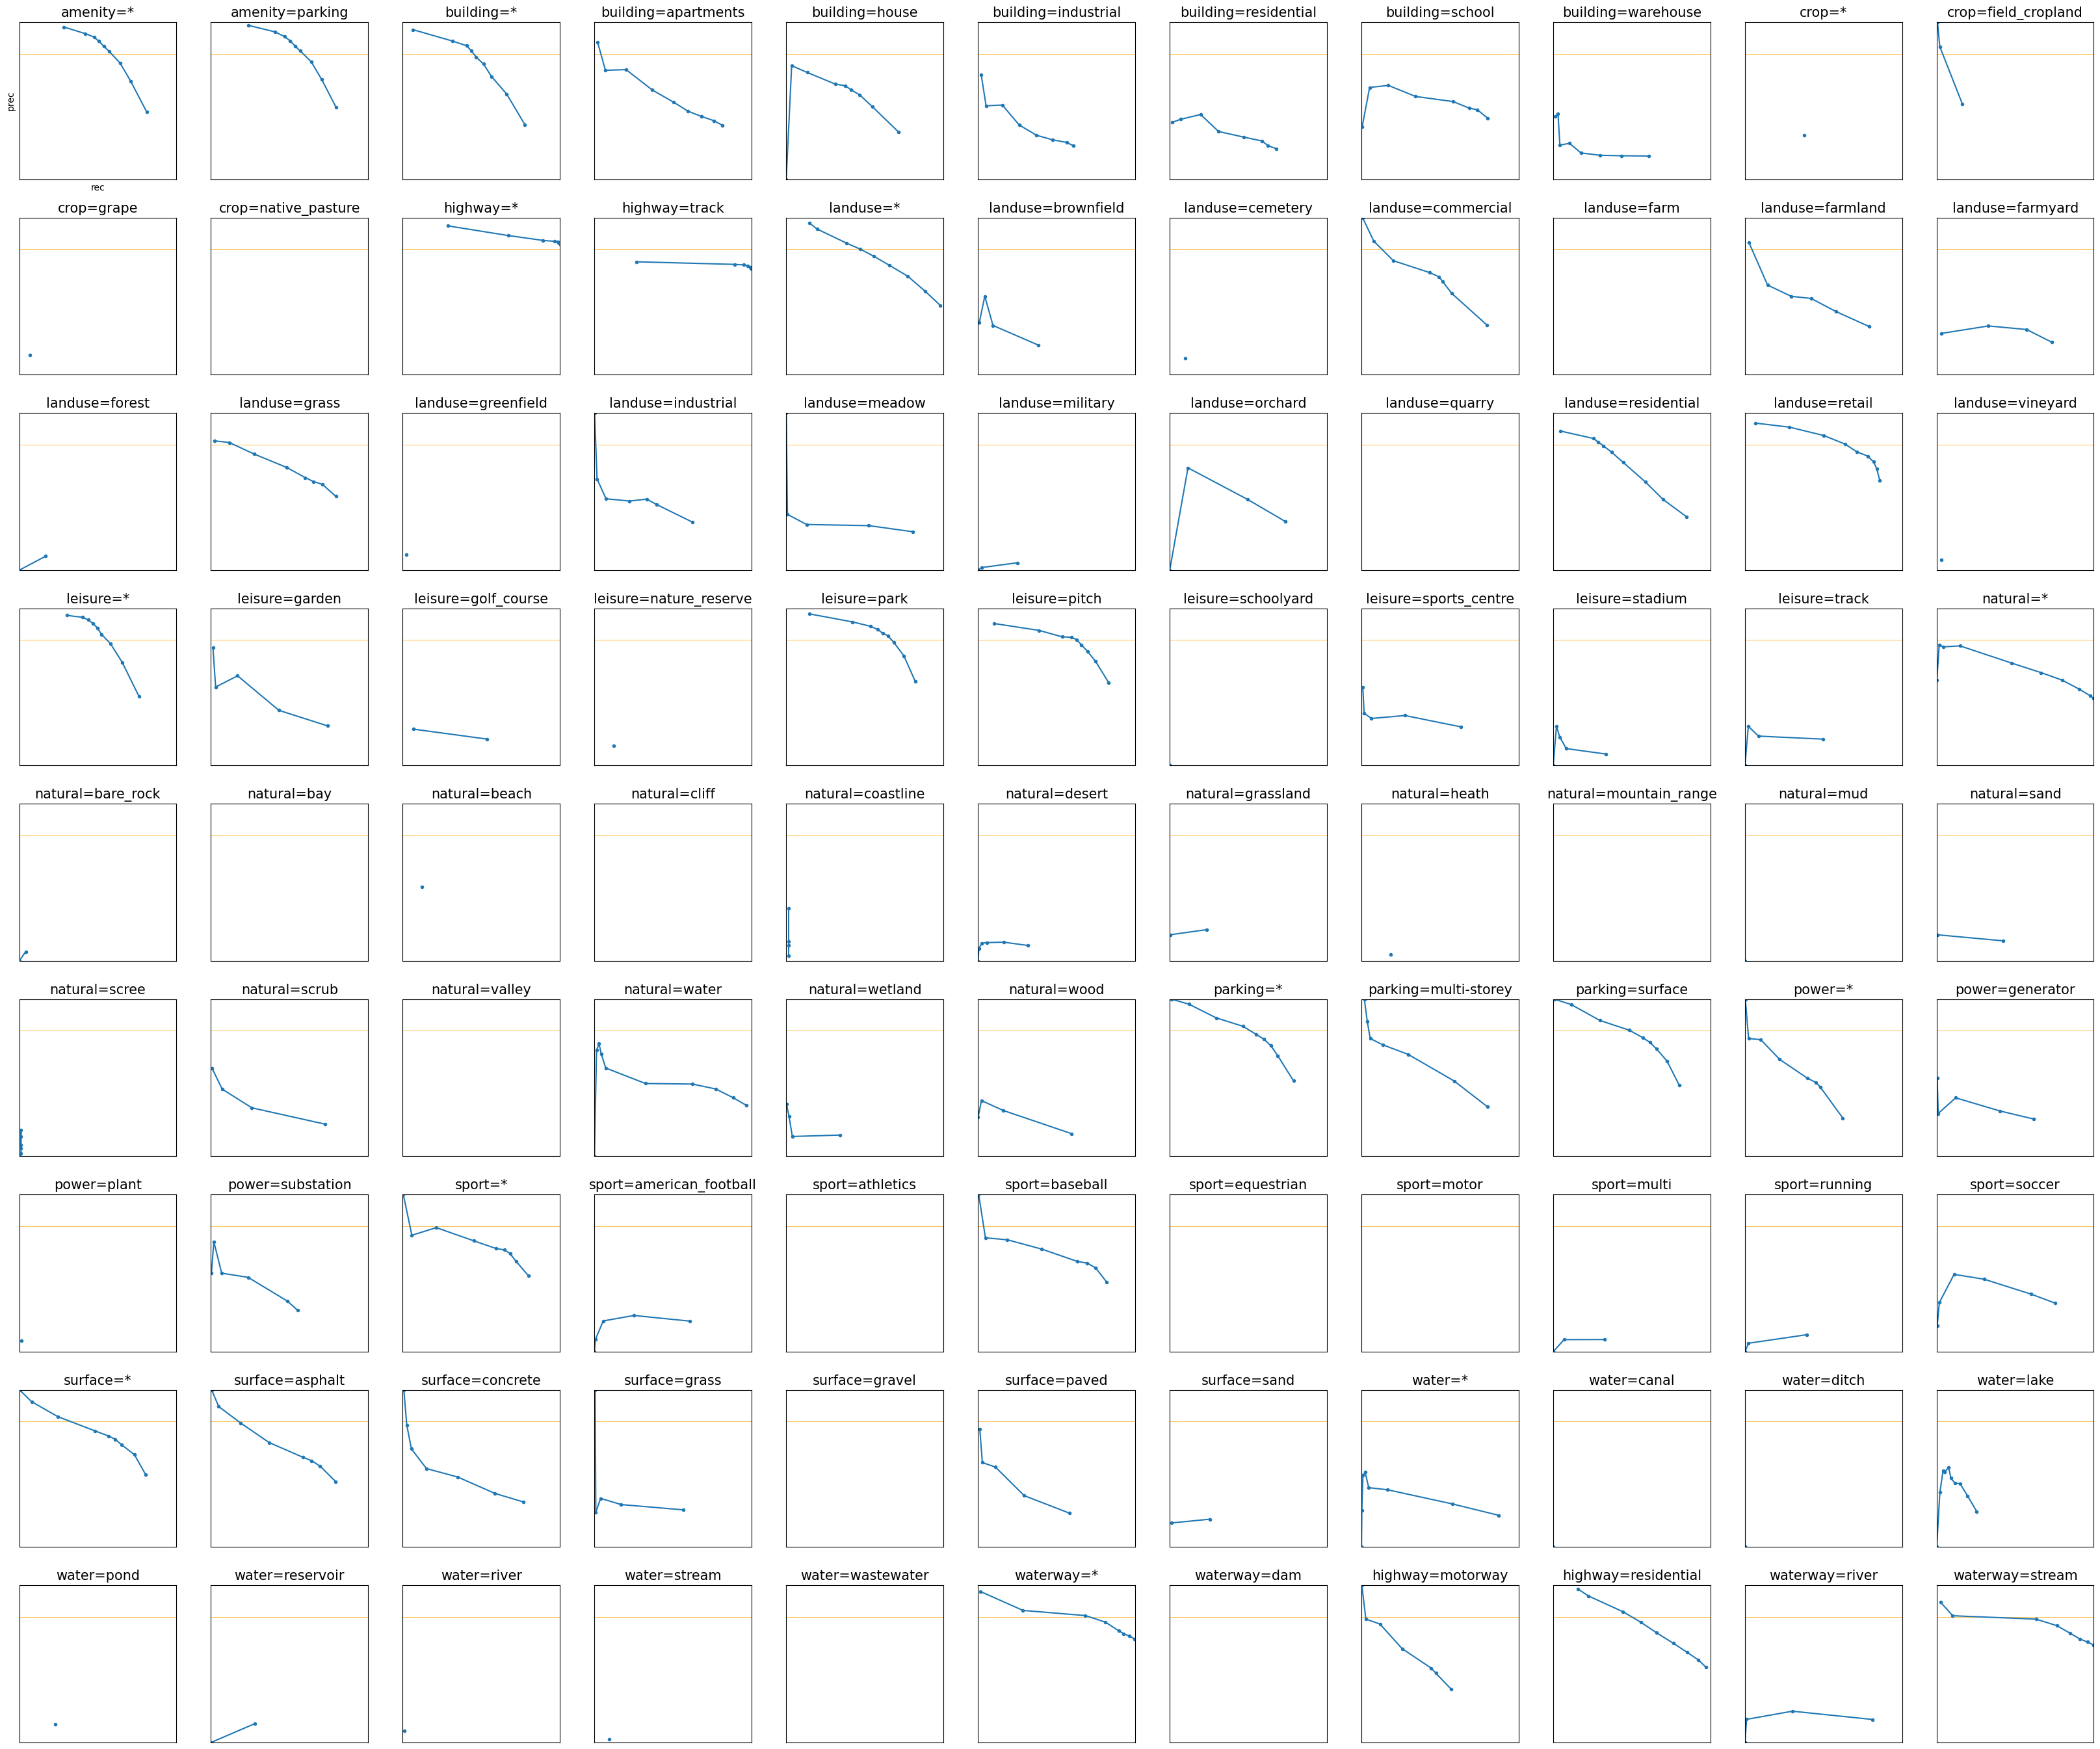

In [26]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=len(classes_retain)//9, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(name_dict[c], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1);
    # if c != 0:
    ax.set_yticks([]); ax.set_xticks([]);
    ax.set_aspect('equal')
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3);
    # for i, thres in enumerate(np.linspace(0.1, 1, 10)):
    #     if None not in R[i, c, :] and np.isfinite(list(R[i, c, :])).all():
    #         ax.text(*R[i, c, :], f"{thres:.1f}", fontsize=10)
plt.tight_layout();

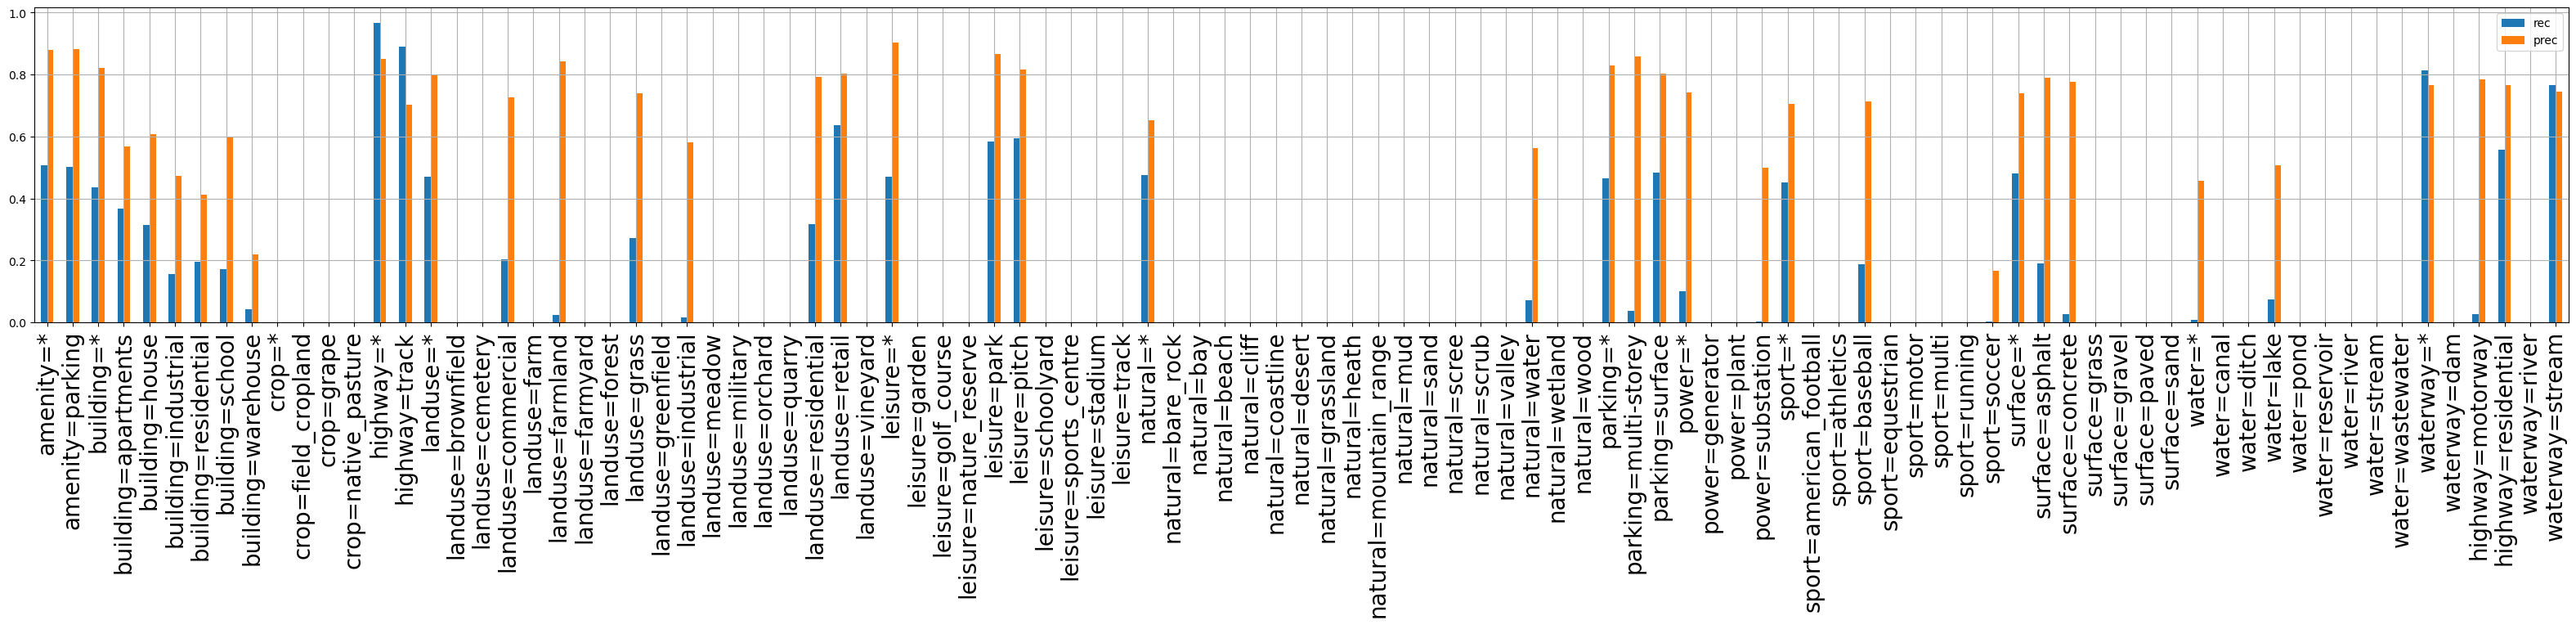

In [25]:
ax = pd.DataFrame(R[5], columns=['rec', 'prec']).plot(kind='bar', figsize=(40,5), grid=True);
ax.set_xticklabels(labels=(name_dict[i] for i in range(len(classes_retain))), rotation=90, fontsize=20);

<Figure size 640x480 with 0 Axes>

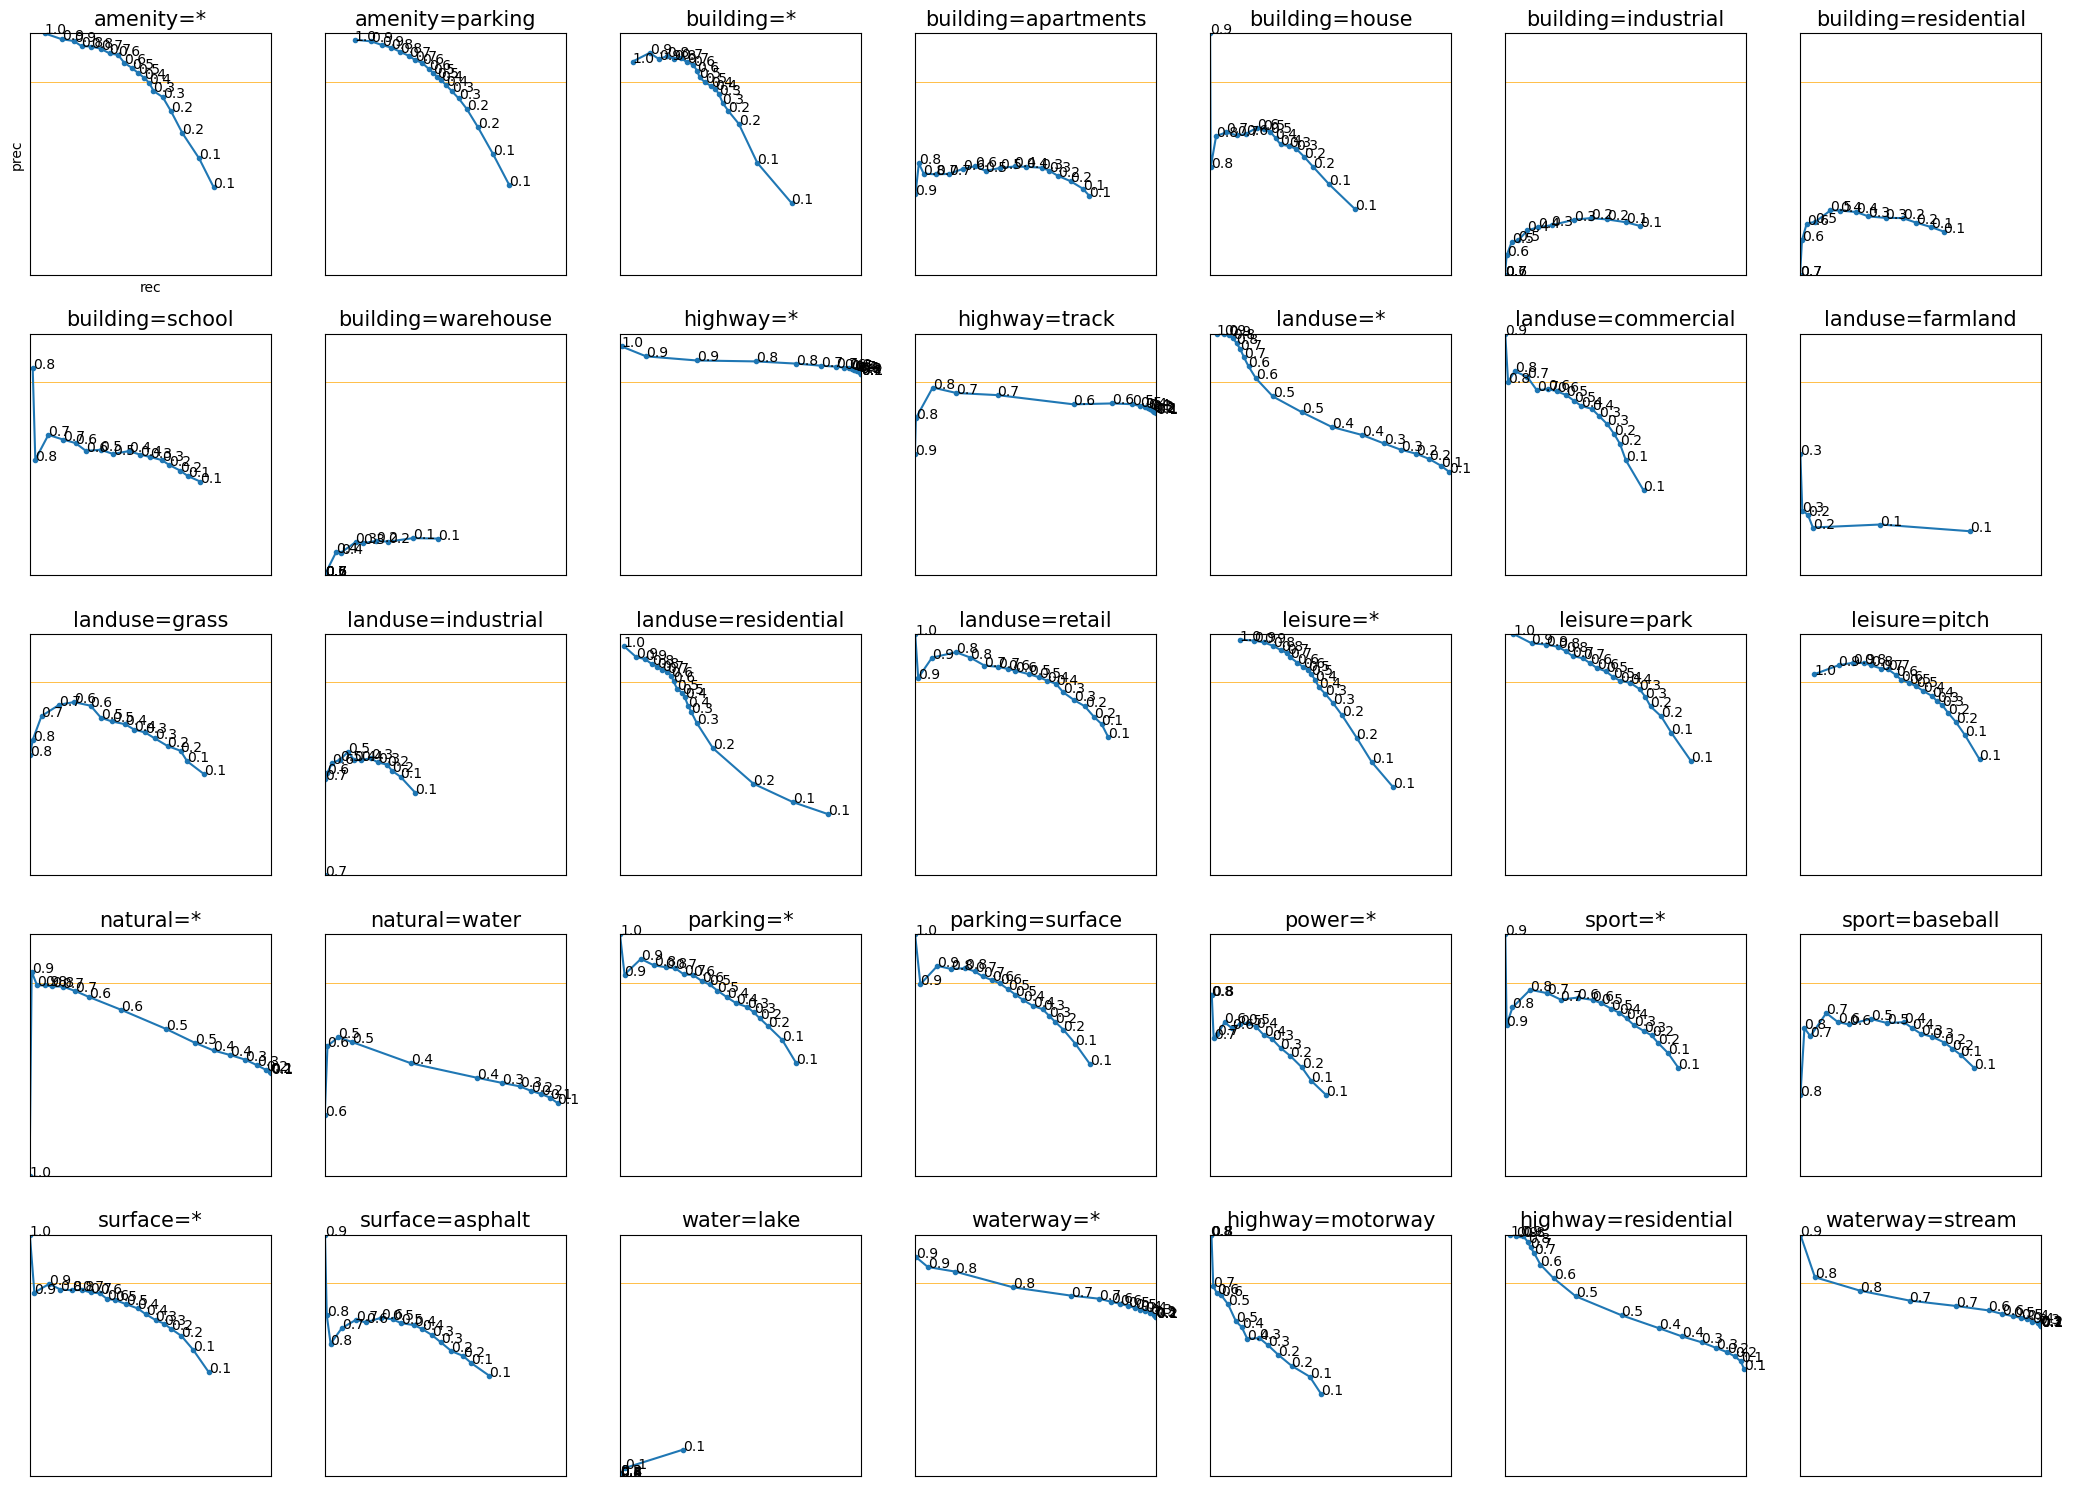

In [52]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=len(classes_retain)//5, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(name_dict[classes_retain[c]], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1);
    # if c != 0:
    ax.set_yticks([]); ax.set_xticks([]);
    ax.set_aspect('equal')
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3);
    for i, thres in enumerate(np.linspace(0.1, 1, 20)):
        if None not in R[i, c, :] and np.isfinite(list(R[i, c, :])).all():
            ax.text(*R[i, c, :], f"{thres:.1f}", fontsize=10)
plt.tight_layout();

#### Which threshold results in precision > 80%

From the above, we can remove the following:
- `building=house, industrial, warehouse`
- `highway=*`
- `landuse=*, residential, vineyard`

Also the following because of redundancy:
- `amenity=*`
<!-- - `building=warehouse`, 8 -->
<!-- - `highway=*`, 13 -->
<!-- - `landuse=*`, 15 -->
<!-- - `landuse=residential`, 30 -->

In [56]:
# e = lambda: np.random.rand()*1e-2

In [55]:
# fig = plt.figure(figsize=(5, 5));

# k = 1
# ax = R[k][['tpr', 'prec']].plot(kind='scatter', x='tpr', y='prec', c='gray', figsize=(7, 7))
# ax.set_xlim(0,1); ax.set_ylim(0,1);

# for i in range(len(np.array(R[k].tpr))):
#     if not np.isnan(np.array(R[k].prec)[i]):
#         ax.text(x=np.array(R[k].tpr)[i] + e(), y=np.array(R[k].prec)[i] + e(), s=name_dict[list(R[k].index)[i]], size=6)